In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import pydot

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [ ]:
review_data= pd.read_csv('/content/drive/MyDrive/Sentiment analysis/new_lstm.csv', encoding= 'unicode_escape')

In [ ]:
print(review_data.head(10))

   uniqueID          drugName                 condition  \
0     92703            Lybrel             Birth Control   
1    221320  Dextromethorphan                     Cough   
2     51215      Azithromycin       Chlamydia Infection   
3    132258            Ativan             Panic Disorde   
4    204999           Toradol                      Pain   
5     71188           Viberzi  Irritable Bowel Syndrome   
6     80520             Mobic            Osteoarthritis   
7     93678          Morphine                      Pain   
8    206444          Trilafon                 Psychosis   
9    221934       Fluconazole   Vaginal Yeast Infection   

                                              review  rating       date  \
0  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
1  "Have a little bit of a lingering cough from a...       4   7-Sep-17   
2  "Was prescribed one dose over the course of on...       7  14-Dec-15   
3  "Honestly, I have been taking ativan for 2 yea.

In [ ]:
print(len(review_data))

300


In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True) 
#review_data['reviewText'] = review_data['reviewText'].apply(remove_url)
review_data['review'] = review_data['review'].apply(clean_text)
review_data['Num_words_text'] = review_data['review'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()
print('Train Max Sentence Length :'+str(max_review_data_sentence_length))
#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Dataset --------
1     56
10    47
5     39
9     31
2     27
6     26
7     22
8     22
3     17
4     13
Name: rating, dtype: int64
300
-------------------------
Train Max Sentence Length :290


In [ ]:
review_data['Num_words_text'].describe()

count    300.000000
mean      65.100000
std       33.384904
min        2.000000
25%       39.000000
50%       65.000000
75%       92.000000
max      290.000000
Name: Num_words_text, dtype: float64

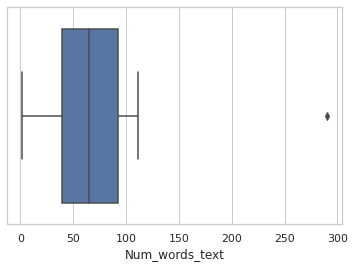

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

In [ ]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
218
No of Long reviews
52


In [ ]:
print(df_short_reviews['Num_words_text'].max())

99


In [ ]:
train_data = review_data[['review','Sentiment']]
print('Train data')
print(train_data['Sentiment'].value_counts())

Train data
 0    100
 1    100
-1    100
Name: Sentiment, dtype: int64


In [ ]:
test_data = review_data[['review','Sentiment']]
print('Test data')
print(test_data['Sentiment'].value_counts())

Test data
 0    100
 1    100
-1    100
Name: Sentiment, dtype: int64


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['review'].tolist(),\
                                                      train_data['Sentiment'].tolist(),\
                                                      test_size=0.3,\
                                                      stratify = train_data['Sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:210
Class distributionCounter({1: 70, 0: 70, -1: 70})
Valid data len:90
Class distributionCounter({1: 30, -1: 30, 0: 30})


In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 132, 46, 47]]


In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)
train_labels = np.asarray(y_train )
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['Sentiment'].tolist())
print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))
print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))
print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:210
Class distributionCounter({1: 70, 0: 70, -1: 70})
Validation data len:90
Class distributionCounter({1: 30, -1: 30, 0: 30})
Test data len:300
Class distributionCounter({0: 100, 1: 100, -1: 100})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[  69  597    4    3   31   52   86   35  470    2  125    4   80    5
 1209 1210 1211    9  193 1212   76   77   28 1213 1214    6  135 1215
   56   72    9  193  765  201 1216  766   62  597  110 1217 1218 1219
  766 1220   69    3  765  201   59   40  109  234   60  767  142   87
   24  109    2   21   69  316  471  768    2   14  317  597   99   94
    4  126 1221    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[ 80 141   1   6 629 267  48  11   1 181  19   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

In [ ]:
max_features =50000
embedding_dim =16
sequence_length = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))                          
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [ ]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 5.0122 - binary_accuracy: 0.3429 - val_loss: 4.7328 - val_binary_accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 0s 418ms/step - loss: 4.7341 - binary_accuracy: 0.3333 - val_loss: 4.4450 - val_binary_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 395ms/step - loss: 4.4302 - binary_accuracy: 0.3381 - val_loss: 4.1501 - val_binary_accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 0s 414ms/step - loss: 4.1592 - binary_accuracy: 0.3286 - val_loss: 3.8537 - val_binary_accuracy: 0.3333
Epoch 5/100
1/1 [==============================] - 0s 351ms/step - loss: 3.8455 - binary_accuracy: 0.3381 - val_loss: 3.5675 - val_binary_accuracy: 0.3333
Epoch 6/100
1/1 [==============================] - 0s 480ms/step - loss: 3.5826 - binary_accuracy: 0.3381 - val_loss: 3.3039 - val_binary_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 0s 475ms/step - loss: 

In [ ]:
history.history

{'loss': [5.012239933013916,
  4.7341203689575195,
  4.430208206176758,
  4.159179210662842,
  3.8454599380493164,
  3.582643747329712,
  3.328847646713257,
  3.0763745307922363,
  3.0306954383850098,
  2.5080010890960693,
  2.3828132152557373,
  1.8526383638381958,
  1.8619762659072876,
  1.6147220134735107,
  1.7554670572280884,
  1.8394603729248047,
  0.9684777855873108,
  0.11768180876970291,
  0.587925374507904,
  -0.8082634210586548,
  -1.7323986291885376,
  -0.06836572289466858,
  -1.3490256071090698,
  -2.726891279220581,
  -1.7666743993759155,
  -4.893819808959961,
  -6.06385612487793,
  -6.754215717315674,
  -13.270838737487793,
  -12.661270141601562,
  -10.81383228302002,
  -16.20844268798828,
  -25.800146102905273,
  -32.81284713745117,
  -39.567176818847656,
  -41.871158599853516,
  -50.599609375,
  -91.02191162109375,
  -80.39028930664062,
  -115.21534729003906,
  -121.83302307128906,
  -129.26071166992188,
  -158.5064239501953,
  -189.9106903076172,
  -170.5317840576172,

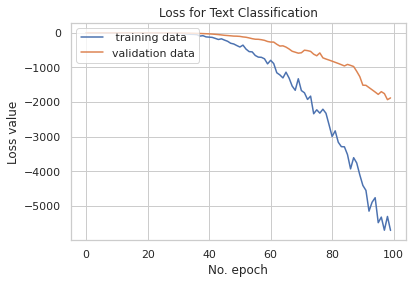

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

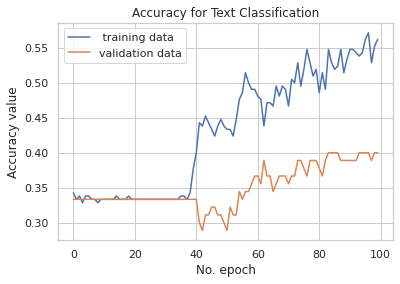

In [ ]:
plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Sentiment analysis/model/tf_lstmmodel.h5') 
json_string = tokenizer.to_json()

In [ ]:
import json
with open('/content/drive/MyDrive/Sentiment analysis/model/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [ ]:
valid_predict= model.predict(x_valid)

In [ ]:
print(valid_predict[:10])

[[0.       ]
 [0.6859364]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.709797 ]
 [0.       ]
 [0.       ]
 [0.8134537]]


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Sentiment analysis/model/tf_lstmmodel.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800016    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           2112      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [ ]:
with open('/content/drive/MyDrive/Sentiment analysis/model/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples


In [ ]:
predictions

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.7179556 ],
       [0.8101742 ],
       [0.7606852 ],
       [0.76442486],
       [0.        ],
       [0.82239443],
       [0.8225826 ],
       [0.7879344 ],
       [0.8071492 ],
       [0.        ],
       [0.        ],
       [0.8004191 ],
       [0.75436765],
       [0.7772688 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.7984053 ],
       [0.        ],
       [0.        ],
       [0.791379  ],
       [0.8072498 ],
       [0.81528354],
       [0.        ],
       [0.8179937 ],
       [0.        ],
       [0.7740148 ],
       [0.73663694],
       [0.7967401 ],
       [0.        ],
       [0.7972945 ],
       [0.7726095 ],
       [0.78547215],
       [0.        ],
       [0.6435627 ],
       [0.8112141 ],
       [0.7647442 ],
       [0.81627977],
       [0.        ],
       [0.709797  ],
       [0.7899071 ],
       [0.        ],
       [0.7441868 ],
       [0.   

In [ ]:
test_data['pred_sentiment'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
max(predictions)

array([0.84132344], dtype=float32)

In [ ]:
min(predictions)

array([0.], dtype=float32)

In [ ]:
test_data['pred_sentiment'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((predictions < 0.1),-1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where(((predictions >= 0.1) & (predictions < 0.7)), 0,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((predictions >= 0.7),1,test_data.pred_sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
test_data['pred_sentiment'].value_counts()

-1    192
 1    108
Name: pred_sentiment, dtype: int64

In [ ]:
labels = [-1, 0, 1]
    
print(classification_report(test_data['Sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

          -1       0.49      0.95      0.65       100
           0       0.00      0.00      0.00       100
           1       0.76      0.82      0.79       100

    accuracy                           0.59       300
   macro avg       0.42      0.59      0.48       300
weighted avg       0.42      0.59      0.48       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 142.81999999999996, 'Predicted')

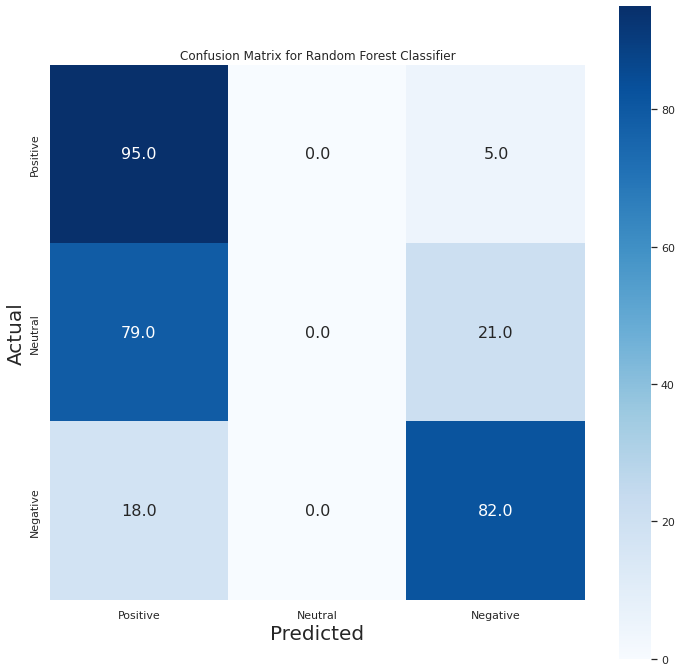

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = test_data['pred_sentiment']
label=['Positive', 'Neutral','Negative']
Ytrue = test_data['Sentiment']
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for Random Forest Classifier")
ax = sns.heatmap(cm, cmap="Blues", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

ROC AUC score: 0.6924999999999999


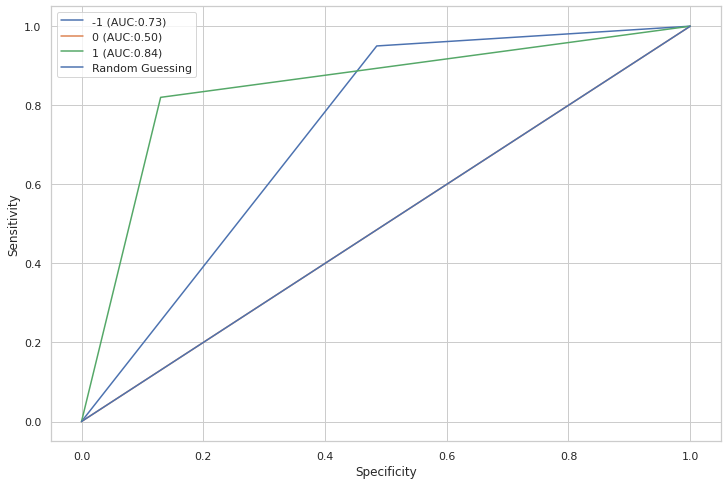

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [-1,0,1]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(Ytrue, Ypred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(Ytrue)
    Ytrue = lb.transform(Ytrue)
    Ypred = lb.transform(Ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(Ytrue[:,idx].astype(int), Ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(Ytrue, Ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(Ytrue, Ypred))

c_ax.legend()
c_ax.set_xlabel('Specificity')
c_ax.set_ylabel('Sensitivity')
plt.show()